In [1]:
from z3 import *

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
from IPython.display import Image

from decisiontree.dt_goal_recogniser import HandcraftedGoalTrees, TrainedDecisionTrees
from evaluation.verification import add_goal_tree_model, extract_counter_example
from core.data_processing import get_dataset
from core.feature_extraction import FeatureExtractor
from core.scenario import ScenarioConfig, Scenario
from core.base import get_data_dir, get_scenario_config_dir, get_img_dir
from core.lanelet_helpers import LaneletHelpers

## Handcrafted goal tree

In [2]:
scenario_name = 'heckstrasse'
model = HandcraftedGoalTrees.load(scenario_name)
reachable_goals = [(1, 'straight-on'), (2, 'turn-left')]

s = Solver()



features, probs, likelihoods = add_goal_tree_model(reachable_goals, s, model)

# unsatisfiable if G2 always has highest prob
verify_expr = Implies(And(features[1]['in_correct_lane'], Not(features[2]['in_correct_lane'])), probs[2] < probs[1])
s.add(Not(verify_expr))

print(s.check())


unsat


verified true:
If car is in correct lane for G1, then G1 is predicted

In [3]:
scenario_name = 'heckstrasse'
model = HandcraftedGoalTrees.load(scenario_name)
reachable_goals = [(1, 'straight-on'), (2, 'turn-left')]

s = Solver()

features, probs, likelihoods = add_goal_tree_model(reachable_goals, s, model)

verify_expr = Implies(And(Not(features[1]['in_correct_lane']),
                          features[2]['in_correct_lane']), probs[2] > probs[1])
s.add(Not(verify_expr))

print(s.check())

unsat


Verified true:
If car is in correct lane for G2, G2 is predicted


# Trained goal tree

In [4]:
scenario_name = 'heckstrasse'
model = TrainedDecisionTrees.load(scenario_name)
reachable_goals = [(1, 'straight-on'), (2, 'turn-left')]

s = Solver()

features, probs, likelihoods = add_goal_tree_model(reachable_goals, s, model)

verify_expr = Implies(And(features[1]['in_correct_lane'],
                          Not(features[2]['in_correct_lane'])),
                      probs[2] < probs[1])
s.add(Not(verify_expr))

print(s.check())

sat


In [5]:
extract_counter_example(s, features, probs, likelihoods)

,1,2
path_to_goal_length,78.0905,57.0985
in_correct_lane,True,False
speed,0,0
acceleration,-1,-1
angle_in_lane,0.03125,0.03125
vehicle_in_front_dist,32.8755,32.8755
vehicle_in_front_speed,0,0
oncoming_vehicle_dist,None,None
goal probability,0.20146,0.79854
goal likelihood,0.0487416,0.924229


In [6]:
likelihoods

{1: likelihood_1_straight-on, 2: likelihood_2_turn-left}

Verification failed: If car is in correct lane for G1, then G1 is predicted.
Becuase: The car is angled to the right (angle_in_lane	0.03125), and is still far from the goal (path_to_goal_length > x) (should replace this with distance to junction entry?), the car is not accelerating, there is no vehicle close in front.

G1 likelihood

## Investigate examples of this

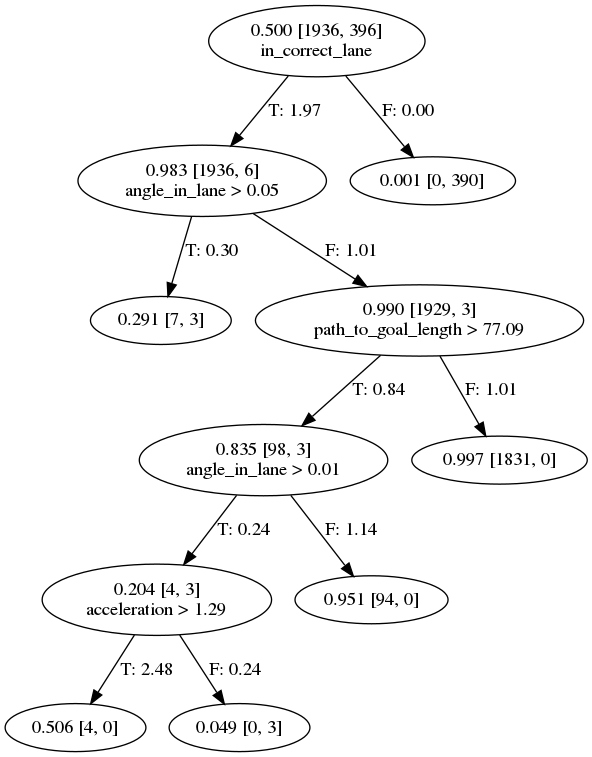

In [7]:
Image("../images/trained_tree_heckstrasse_G1_straight-on.png")

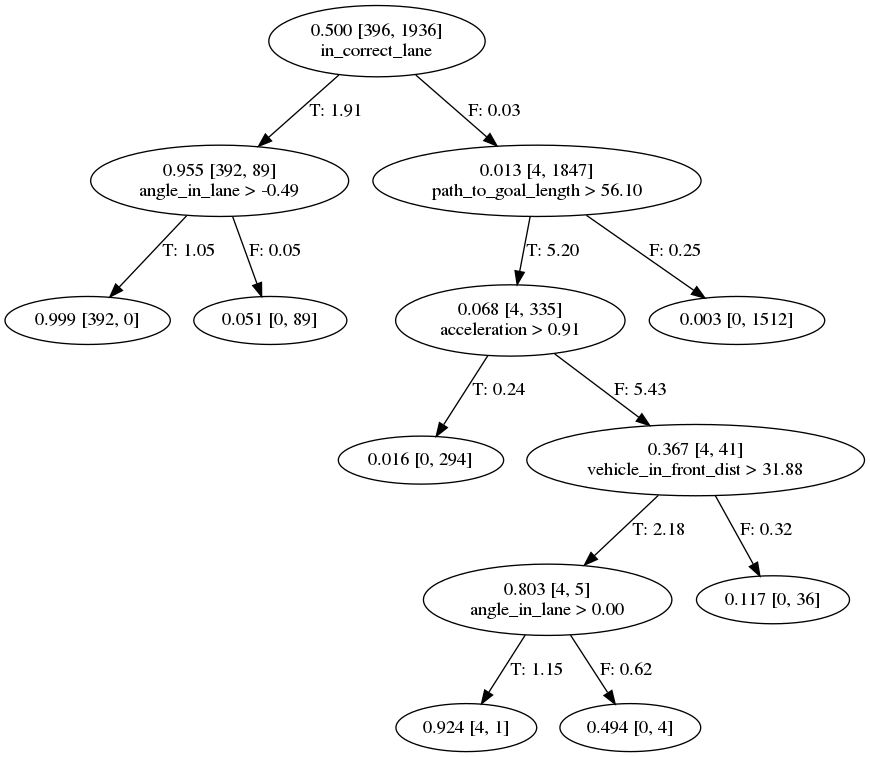

In [8]:
Image("../images/trained_tree_heckstrasse_G2_turn-left.png")

In [9]:
dataset = get_dataset(scenario_name, 'train')

In [10]:
scenario = Scenario.load(get_scenario_config_dir() + '{}.json'.format(scenario_name))

In [11]:
feature_extractor = FeatureExtractor(scenario.lanelet_map)

In [12]:
episode = scenario.load_episode(0)

In [13]:
state = episode.frames[8292].agents[114]

In [14]:
goal_routes = feature_extractor.get_goal_routes(state, scenario.config.goals)

ID -1770527: Linestring type must be specified
Found the following unknown types, did not plot them: ['wall', 'arrow']


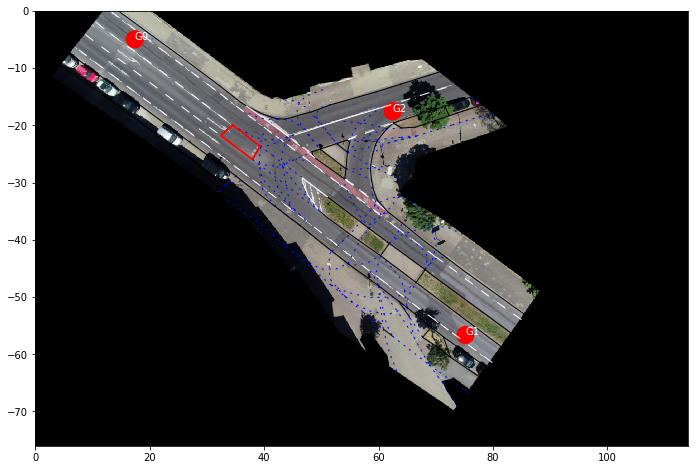

In [15]:
plt.figure(figsize=(12,8))
scenario.plot()
LaneletHelpers.plot(goal_routes[1].shortestPath()[0])

ID -1770527: Linestring type must be specified
Found the following unknown types, did not plot them: ['wall', 'arrow']


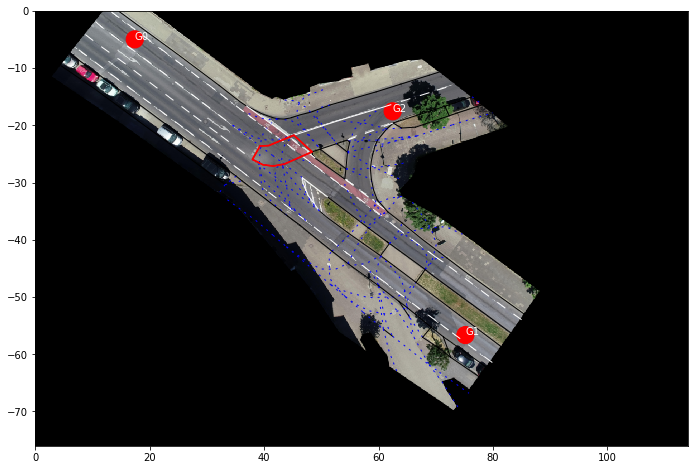

In [16]:
plt.figure(figsize=(12,8))
scenario.plot()
LaneletHelpers.plot(goal_routes[2].shortestPath()[0])

In [17]:
dataset.loc[(dataset.in_correct_lane)  
            & (dataset.angle_in_lane > 0.05)
           & (dataset.possible_goal==1) & (dataset.goal_type=='straight-on')]

,path_to_goal_length,in_correct_lane,speed,acceleration,angle_in_lane,vehicle_in_front_dist,vehicle_in_front_speed,oncoming_vehicle_dist,goal_type,agent_id,possible_goal,true_goal,true_goal_type,frame_id,initial_frame_id,fraction_observed,episode
1103,57.251157,True,8.44261,0.94966,0.056181,17.062702,9.16979,100.0,straight-on,59,1,1,straight-on,3002,2932,0.7,2
1109,46.418964,True,9.55601,0.77053,0.054021,17.376592,9.41500,100.0,straight-on,59,1,1,straight-on,3032,2932,1.0,2
1237,48.281868,True,7.59623,1.78476,0.061450,37.837248,9.25895,100.0,straight-on,64,1,1,straight-on,3262,3192,1.0,2
1414,51.088326,True,4.15435,1.77150,0.055342,100.000000,20.00000,100.0,straight-on,72,1,1,straight-on,3762,3564,0.9,2
1416,46.693093,True,5.88367,2.04481,0.057562,100.000000,20.00000,100.0,straight-on,72,1,1,straight-on,3784,3564,1.0,2
2946,73.281020,True,10.46112,0.02086,0.050708,48.553097,14.39683,100.0,straight-on,144,1,2,turn-left,7494,7484,0.1,2
5632,45.574786,True,3.95654,1.10213,0.536447,24.257528,8.99368,100.0,straight-on,275,1,2,turn-left,14329,13669,1.0,2
7831,73.509990,True,13.70909,2.86297,0.056215,100.000000,20.00000,100.0,straight-on,402,1,1,straight-on,21862,21857,0.1,2
7833,70.671521,True,14.28047,2.33190,0.053617,100.000000,20.00000,100.0,straight-on,402,1,1,straight-on,21867,21857,0.2,2
8132,45.654696,True,4.55170,1.08278,0.533692,100.000000,20.00000,100.0,straight-on,420,1,2,turn-left,22817,22427,1.0,2


Reasons for wrong lane:
1. Start of trajectory, has not yet changed lane

heckstrasse agent 114 frame 8292 get current lanelet?


In [18]:
scenario_name = 'heckstrasse'
model = TrainedDecisionTrees.load(scenario_name)
reachable_goals = [(1, 'straight-on'), (2, 'turn-left')]

s = Solver()

features, probs, likelihoods = add_goal_tree_model(reachable_goals, s, model)


verify_expr = Implies(And(Not(features[1]['in_correct_lane']), features[2]['in_correct_lane']), probs[2] > probs[1])
s.add(Not(verify_expr))

print(s.check())

unsat


Verified true: If car is in correct lane for G2, G2 is predicted

# Verify bound on probability if in the correct lane
If we are in the correct lane for a goal, the the probabilty of that goal should be > 0.2
Heckstrasse - coming from west

In [19]:
scenario_name = 'heckstrasse'
model = TrainedDecisionTrees.load(scenario_name)
reachable_goals = [(1, 'straight-on'), (2, 'turn-left')]

s = Solver()

features, probs, likelihoods = add_goal_tree_model(reachable_goals, s, model)


verify_expr = Implies(And(features[1]['in_correct_lane'],
                          Not(features[2]['in_correct_lane'])), probs[1] >= 0.2)
s.add(Not(verify_expr))

print(s.check())

unsat


In [20]:
scenario_name = 'heckstrasse'
model = TrainedDecisionTrees.load(scenario_name)
reachable_goals = [(1, 'straight-on'), (2, 'turn-left')]

s = Solver()

features, probs, likelihoods = add_goal_tree_model(reachable_goals, s, model)


verify_expr = Implies(And(Not(features[1]['in_correct_lane']),
                          features[2]['in_correct_lane']), probs[2] >= 0.2)
s.add(Not(verify_expr))

print(s.check())

unsat


For both goals, this is verified to be true

# Verify prob based on angle in lane, approaching T Junction

In [21]:
scenario_name = 'heckstrasse'
model = TrainedDecisionTrees.load(scenario_name)
reachable_goals = [(0, 'turn-right'), (1, 'turn-left')]

s = Solver()

features, probs, likelihoods = add_goal_tree_model(reachable_goals, s, model)

s.add(features[0]['angle_in_lane'] >= np.pi / 8)
s.add(features[1]['angle_in_lane'] >= np.pi / 8)

verify_expr =  probs[1] >= 0.1
s.add(Not(verify_expr))

print(s.check())

sat


In [22]:
extract_counter_example(s, features, probs, likelihoods)

,0,1
path_to_goal_length,33.9457,53.4493
in_correct_lane,None,None
speed,7,7
acceleration,1,1
angle_in_lane,2,2
vehicle_in_front_dist,0,0
vehicle_in_front_speed,-0.5,-0.5
oncoming_vehicle_dist,29.5547,None
goal probability,0.985276,0.0147243
goal likelihood,0.987513,0.0124873


Becuase speed > 5.53
In the trainin set, all vehicles with speed > 5.53 turned right

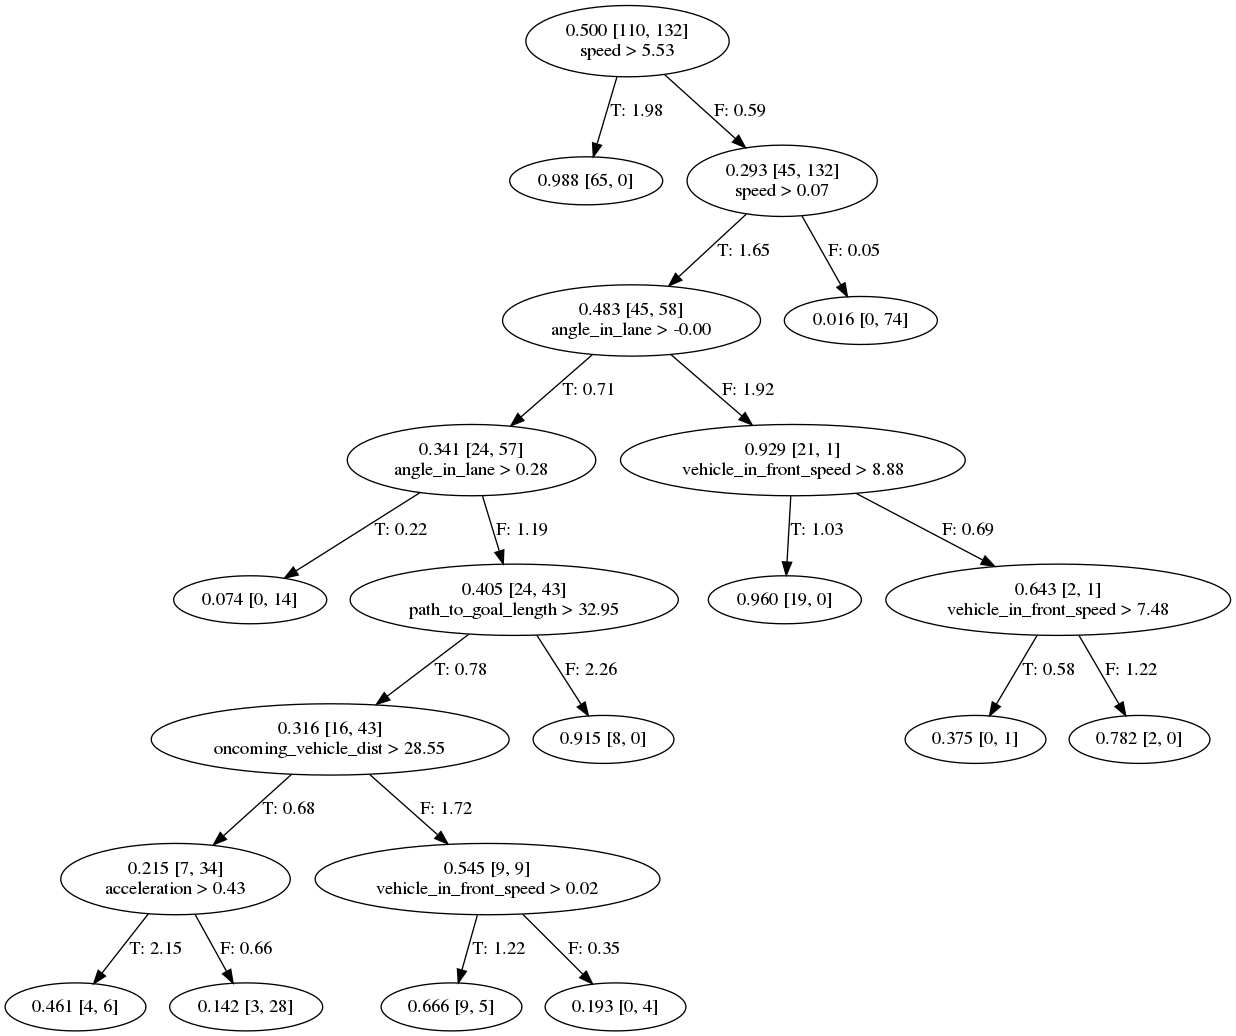

In [23]:
Image("../images/trained_tree_heckstrasse_G0_turn-right.png")

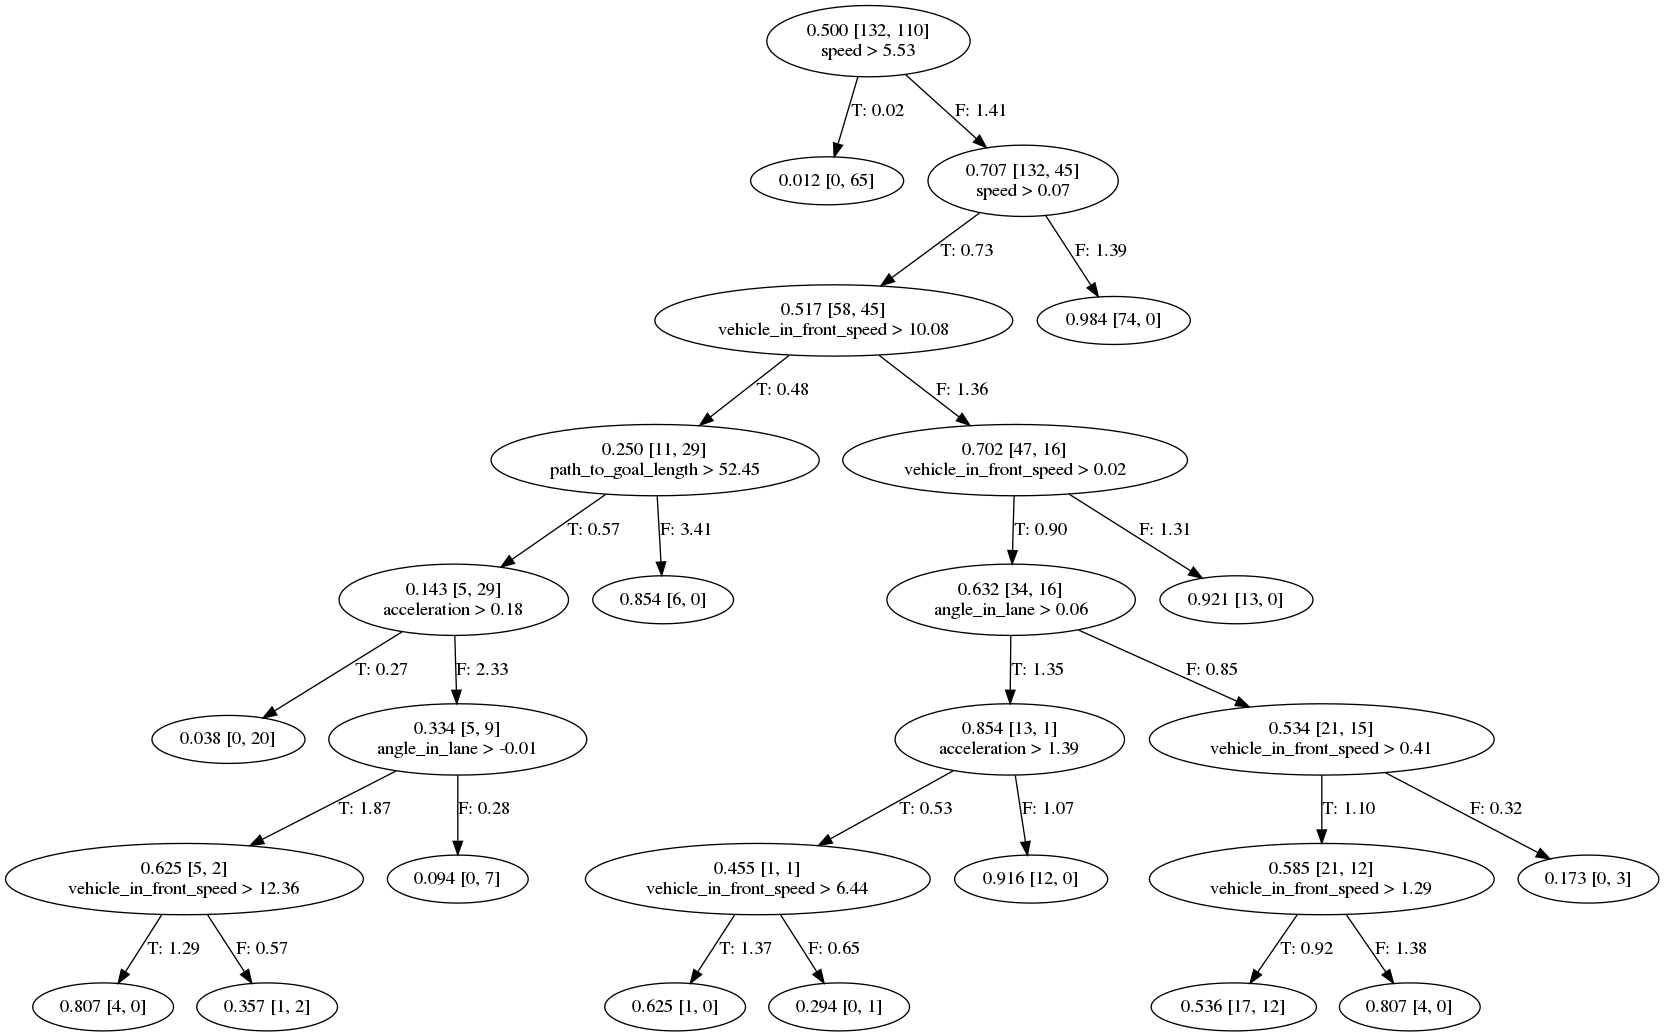

In [24]:
Image("../images/trained_tree_heckstrasse_G1_turn-left.png")

# Verify that decreasing path to goal length leads to decreasing entropy
Can easily be done when there are two goals
Start with heckstrasse approaching from west

In [25]:
scenario_name = 'heckstrasse'
model = TrainedDecisionTrees.load(scenario_name)
reachable_goals = [(1, 'straight-on'), (2, 'turn-left')]

s = Solver()

# 2 has shorter path to goal length than 1, but all other features are equal
features1, probs1, likelihoods1 = add_goal_tree_model(reachable_goals, s, model, suffix='_1')
features2, probs2, likelihoods2 = add_goal_tree_model(reachable_goals, s, model, suffix='_2')

for goal_idx, goal_type in reachable_goals:
    s.add(features1[goal_idx]['path_to_goal_length'] \
          > features2[goal_idx]['path_to_goal_length'])
    
    for feature_name in features1[goal_idx]:
        if feature_name != 'path_to_goal_length':
            s.add(features1[goal_idx][feature_name] == features2[goal_idx][feature_name])


verify_expr = And(Implies(probs1[1] < probs1[2], probs2[2] >= probs1[2]), 
                  Implies(probs1[1] > probs1[2], probs2[1] >= probs1[1]))

s.add(Not(verify_expr))


print(s.check())

sat


In [26]:
extract_counter_example(s, features1, probs1, likelihoods1)

,1,2
path_to_goal_length,0.5,58
in_correct_lane,False,False
speed,0,0
acceleration,2,2
angle_in_lane,-1,-1
vehicle_in_front_dist,32.8755,32.8755
vehicle_in_front_speed,0,0
oncoming_vehicle_dist,0,0
goal probability,0.133479,0.866521
goal likelihood,0.00052391,0.0162702


In [27]:
extract_counter_example(s, features2, probs2, likelihoods2)

,1,2
path_to_goal_length,-1,55
in_correct_lane,False,False
speed,0,0
acceleration,2,2
angle_in_lane,-1,-1
vehicle_in_front_dist,32.8755,32.8755
vehicle_in_front_speed,0,0
oncoming_vehicle_dist,0,0
goal probability,0.438107,0.561893
goal likelihood,0.00052391,0.00321441


verification failed
Counterexample:
path_to_goal_length_1_1 = -1/4
path_to_goal_length_1_2 = -2

This features caused the difference:
path_to_goal_length_2_1 = 62
path_to_goal_length_2_2 = 59

likelihood_2_turn-left_1 = 0.032
likelihood_2_turn-left_2 = 0.002

likelihood_1_straight-on_1 = 0.0003
likelihood_1_straight-on_2 = 0.0003

in_correct_lane is false for both goals - should not be possible

## Try verification again, restricting feature values based on domain knowledge

Eventually domain model / feature extraction could be represented in logic

In [28]:
scenario_name = 'heckstrasse'
model = TrainedDecisionTrees.load(scenario_name)
reachable_goals = [(1, 'straight-on'), (2, 'turn-left')]

s = Solver()

# 2 has shorter path to goal length than 1, but all other features are equal
features1, probs1, likelihoods1 = add_goal_tree_model(reachable_goals, s, model, suffix='_1')
features2, probs2, likelihoods2 = add_goal_tree_model(reachable_goals, s, model, suffix='_2')

for goal_idx, goal_type in reachable_goals:
    s.add(features1[goal_idx]['path_to_goal_length'] \
          > features2[goal_idx]['path_to_goal_length'])
    
    for feature_name in features1[goal_idx]:
        if feature_name != 'path_to_goal_length':
            s.add(features1[goal_idx][feature_name] == features2[goal_idx][feature_name])

s.add(features1[1]['in_correct_lane'] != features1[2]['in_correct_lane'])

            
verify_expr = And(Implies(probs1[1] < probs1[2], probs2[2] >= probs1[2]), 
                  Implies(probs1[1] > probs1[2], probs2[1] >= probs1[1]))

s.add(Not(verify_expr))


print(s.check())

sat


In [29]:
extract_counter_example(s, features1, probs1, likelihoods1)

,1,2
path_to_goal_length,79,58
in_correct_lane,True,False
speed,0,0
acceleration,0,0
angle_in_lane,0.03125,0.03125
vehicle_in_front_dist,32.8755,32.8755
vehicle_in_front_speed,0,0
oncoming_vehicle_dist,0,0
goal probability,0.20146,0.79854
goal likelihood,0.0487416,0.924229


In [30]:
extract_counter_example(s, features2, probs2, likelihoods2)

,1,2
path_to_goal_length,78,55
in_correct_lane,True,False
speed,0,0
acceleration,0,0
angle_in_lane,0.03125,0.03125
vehicle_in_front_dist,32.8755,32.8755
vehicle_in_front_speed,0,0
oncoming_vehicle_dist,0,0
goal probability,0.986402,0.0135983
goal likelihood,0.0487416,0.00321441


Not verified - different child node reached  depending path to goal length
When further from goal, acceleration is informative - high acceleration means lower G2 likelihood

Looks like overfitting - see tree below

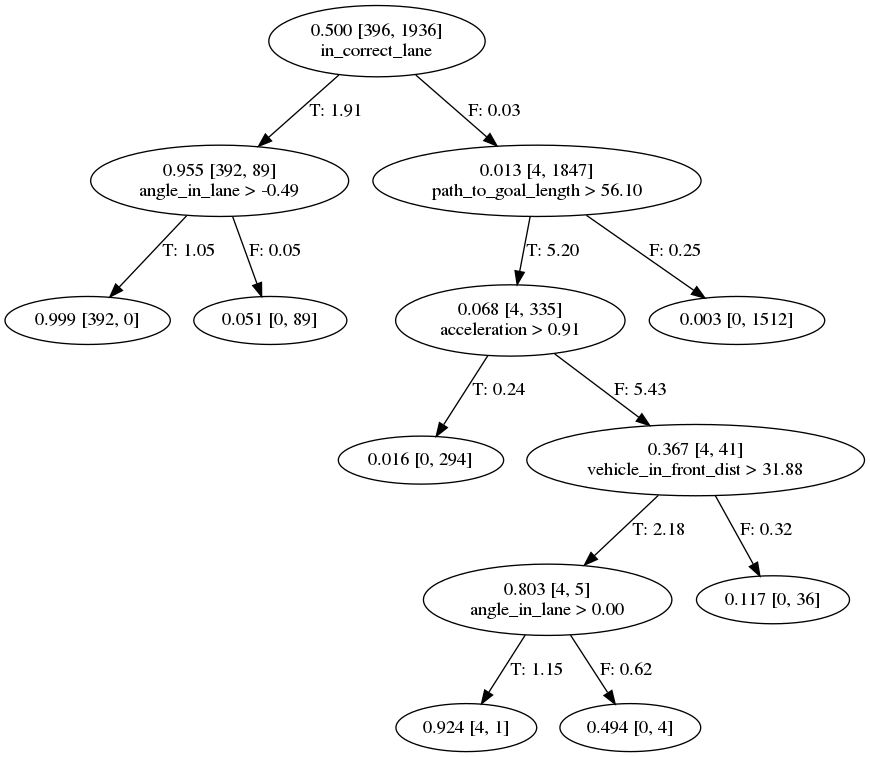

In [33]:
Image('../images/trained_tree_heckstrasse_G2_turn-left.png')